In [1]:
import json, re, time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem.snowball import DutchStemmer
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
# data = pd.read_csv('./uitspraken Tweede Kamer 2015-2016.csv')
# for f in ['2014-2015', '2013-2014']:
#     data = data.append(pd.read_csv('./uitspraken Tweede Kamer '+f+'.csv', encoding='latin1'))

In [ ]:
# len(data)

In [ ]:
# # We kijken nu alleen naar uitspraken gekoppeld aan een partij
# data = data.dropna()
# len(data)

### Clean text

In [3]:
stemmer = DutchStemmer()
def clean(t):
    t = t.replace('D66', 'Dzesenzestig') # om te voorkomen dat D66 en 50PLUS verdwijnen bij het verwijderen van cijfers
    t = t.replace('50PLUS', 'vijftigPLUS')
    t = re.sub("[^a-zA-Z]", " ", t) # alleen letters
    t = t.lower().split() # alles naar kleine letters (geen hoofdletters), opslitsen naar lijst met woorden
    t = [stemmer.stem(w) for w in t if not w in stopwords.words("dutch")] # stopwoorden er uit, en stem
    t = ' '.join(t) # terug samenvoegen tot lap tekst
    return t

In [ ]:
# t0 = time.time()
# data['Uitspraak clean'] = data['Uitspraak'].apply(clean)
# print(time.time()-t0)

In [ ]:
# data.to_csv('./uitspraken Tweede Kamer 2013-2016 partijen clean.csv')

In [4]:
data = pd.read_csv('./uitspraken Tweede Kamer 2013-2016 partijen clean.csv', encoding='latin1')

In [5]:
data['Word count'] = data['Uitspraak clean'].apply(lambda x: len(str.split(str(x))))

In [6]:
data.head()

,Unnamed: 0,Naam,Partij,Uitspraak,Uitspraak clean,Word count
0,6,Wilders,PVV,\r\nVoorzitter. De situatie met betrekking tot...,voorzitter situatie betrek asieltsunami land r...,100
1,8,Van Haersma Buma,CDA,\r\nDe CDA-fractie deelt de analyse over de er...,cda fractie deelt analys ernst urgentie proble...,53
2,10,Slob,ChristenUnie,"\r\nHet zijn Algemene Beschouwingen, dus staat...",algemen beschouw stat ieder fractie vrij eig t...,27
3,11,Van der Staaij,SGP,\r\nOok de SGP vindt dat het een heel belangri...,sgp vindt hel belangrijk vraagstuk we uitstek ...,17
4,12,Thieme,PvdD,\r\nIk zie geen reden waarom we het niet vanda...,zie red waarom we vandag tijden debat uitvoer ...,11


In [7]:
data['Partij'].value_counts()

SP                           18114
D66                          16062
CDA                          15289
VVD                          15186
PvdA                         14710
PVV                          10548
GroenLinks                    8603
ChristenUnie                  7803
SGP                           3903
PvdD                          2884
50PLUS                        1359
Groep Bontes/Van Klaveren      608
Van Vliet                      581
Groep Kuzu/Öztürk              561
Klein                          512
50PLUS/Klein                   156
Bontes                         137
Houwers                        112
50PLUS/Baay-Timmerman           62
50PLUS/Krol                      3
EP/CU/SGP                        2
EP/SP                            2
EP/VVD                           2
EP/PvdD                          2
EP/PvdA                          2
EP/D66                           2
EP/CDA                           2
EP/GroenLinks                    1
Name: Partij, dtype:

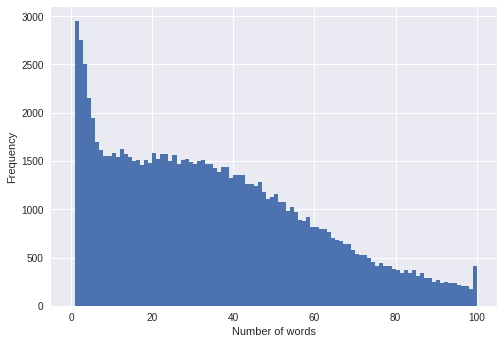

In [6]:
data['Word count'].plot.hist(range=[0,100], bins=100)
plt.xlabel('Number of words')
plt.show()

In [7]:
data = data[data['Word count'] >= 20]

In [8]:
len(data)

83165

In [25]:
data['Partij'].value_counts()

SP              12848
D66             11418
VVD             11268
CDA             10862
PvdA            10705
PVV              7151
GroenLinks       6100
ChristenUnie     5766
SGP              2608
PvdD             1940
50PLUS            783
Name: Partij, dtype: int64

In [26]:
# pak alleen partijen die minstens 500 keer voorkomen
data = data[data['Partij'].isin(data['Partij'].value_counts().index[(data['Partij'].value_counts()>500).values])]

In [27]:
len(data)

81449

### Bag of words

In [33]:
X = data['Uitspraak clean']
y = data['Partij']

In [11]:
t0 = time.time()
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
X_counts = count_vect.fit_transform(X)
print(time.time()-t0)
print(X_counts.shape)

11.295029401779175
(83165, 83877)


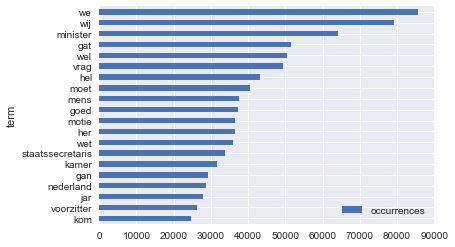

In [12]:
# meest voorkomende woorden
occ = np.asarray(count_vect.transform(X).sum(axis=0)).ravel().tolist()
counts_df = pd.DataFrame({'term': count_vect.get_feature_names(), 'occurrences': occ})
counts_df.sort_values(by='occurrences', ascending=False).head(20).set_index('term').plot.barh()
plt.gca().invert_yaxis();

In [57]:
# TF-IDF
t0 = time.time()
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vect = TfidfVectorizer()
X_tfidf = tfidf_vect.fit_transform(X)
print(time.time()-t0)
print(X_tfidf.shape)

6.9620068073272705
(81449, 82725)


### Feature selection

In [63]:
from sklearn.feature_selection import SelectPercentile
SP = SelectPercentile()
X_tfidf = SP.fit_transform(X_tfidf, y=y)

In [69]:
terms = np.asarray(tfidf_vect.get_feature_names())[SP.get_support()]

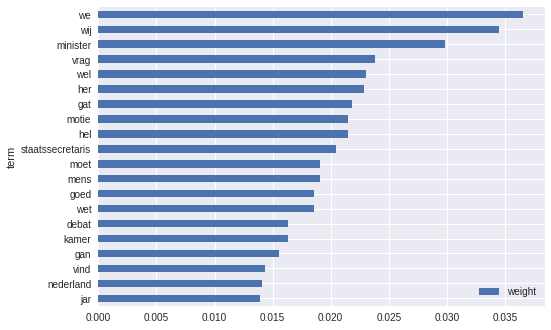

In [70]:
# hoogste TF-IDF scores
weights = np.asarray(X_tfidf.mean(axis=0)).ravel().tolist()
weights_df = pd.DataFrame({'term': terms, 'weight': weights})
weights_df.sort_values(by='weight', ascending=False).head(20).set_index('term').plot.barh()
plt.gca().invert_yaxis();

### Classify

In [20]:
# from sklearn.linear_model import SGDClassifier
# from sklearn.pipeline import Pipeline

# text_clf = Pipeline([('vect', CountVectorizer()),
#                      ('tfidf', TfidfTransformer()),
#                      ('clf', SGDClassifier(loss='hinge', penalty='l2',
#                                            alpha=1e-3, n_iter=10)),
# ])

*Note:* use StratifiedKFold or KFold with shuffle=True for cross validation unless classes are uniformly distributed in the data (usually not the case).

See here: https://stackoverflow.com/questions/43688058/sklearn-cross-val-score-gives-lower-accuracy-than-manual-cross-validation


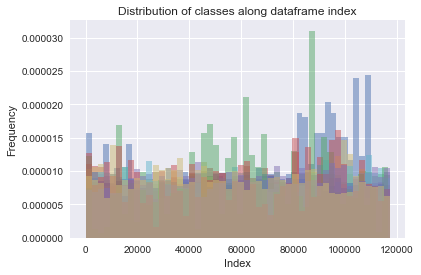

In [25]:
data.reset_index().groupby('Partij')['index'].plot.hist(alpha=.5, normed=True, bins=50)
plt.title('Distribution of classes along dataframe index')
plt.xlabel('Index')
plt.show()

In [86]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier

# text_clf = DecisionTreeClassifier()
# text_clf = RandomForestClassifier(n_jobs=-1)
text_clf = SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, n_iter=10)

In [38]:
from sklearn.model_selection import cross_val_score
import sklearn.model_selection as ms

In [ ]:
# # without shuffling
# scores = cross_val_score(text_clf, X, y, n_jobs=-1, scoring='accuracy', verbose=1,
#                          cv=ms.StratifiedKFold(n_splits=10, shuffle=False))
# print(scores)
# print(scores.mean())

In [39]:
# with shuffling
scores = cross_val_score(text_clf, X_tfidf, y, n_jobs=-1, scoring='accuracy', verbose=1,
                         cv=ms.StratifiedKFold(n_splits=10, shuffle=True))
print(scores)
print(scores.mean())

[ 0.18910296  0.19256259  0.19393642  0.19052296  0.18745397  0.19680786
  0.20567289  0.19744597  0.19262899  0.20331695]
0.194945155301


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  2.0min finished


In [131]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X_tfidf, y, test_size=0.1)
text_clf = text_clf.fit(X_train, y_train)
print(text_clf.score(X_test, y_test))

0.455739717618


In [132]:
from sklearn import metrics
print(metrics.classification_report(y_test, text_clf.predict(X_test)))

              precision    recall  f1-score   support

      50PLUS       0.58      0.59      0.59        76
         CDA       0.48      0.42      0.45      1109
ChristenUnie       0.41      0.43      0.42       554
         D66       0.42      0.30      0.35      1128
  GroenLinks       0.49      0.33      0.39       590
         PVV       0.46      0.64      0.54       714
        PvdA       0.43      0.43      0.43      1081
        PvdD       0.58      0.62      0.60       211
         SGP       0.46      0.49      0.47       243
          SP       0.45      0.57      0.50      1315
         VVD       0.47      0.45      0.46      1124

 avg / total       0.46      0.46      0.45      8145



precision  $P = \frac{T_p}{T_p+F_p}$

recall $R = \frac{T_p}{T_p+F_n}$

f1-score = $2\frac{P*R}{P+R}$

In [133]:
# a = pd.DataFrame(np.array([terms, text_clf.feature_importances_]).T, columns=['Term', 'Feature importance'])
# a.sort_values(by='Feature importance', ascending=False).head(10)

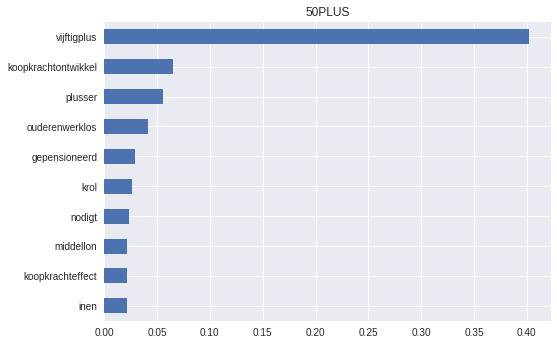

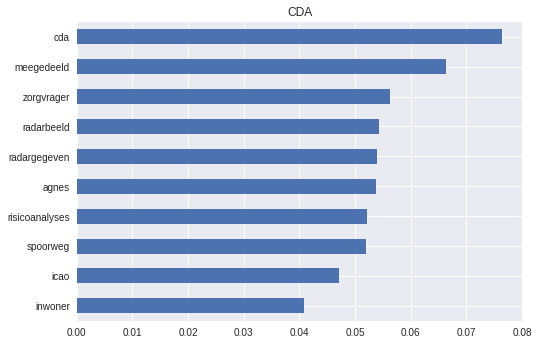

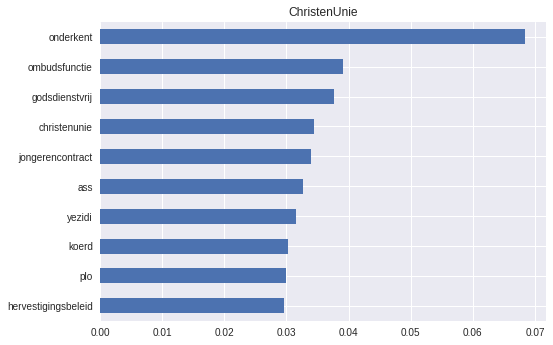

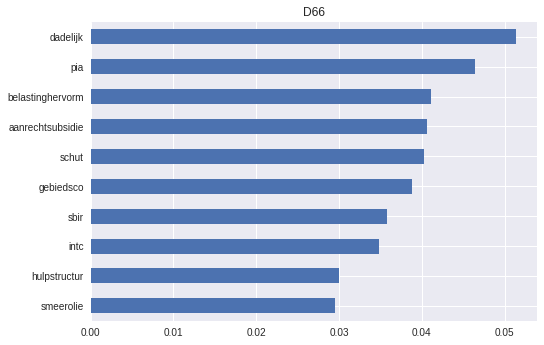

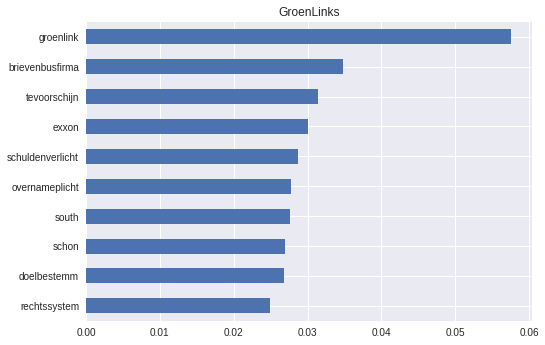

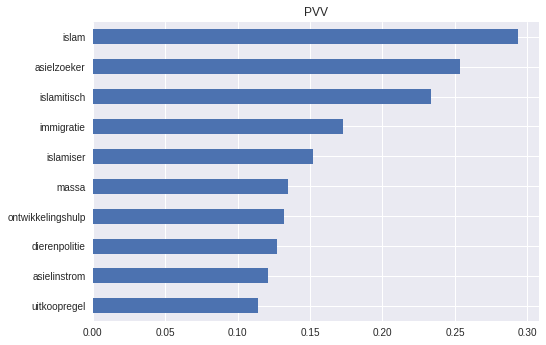

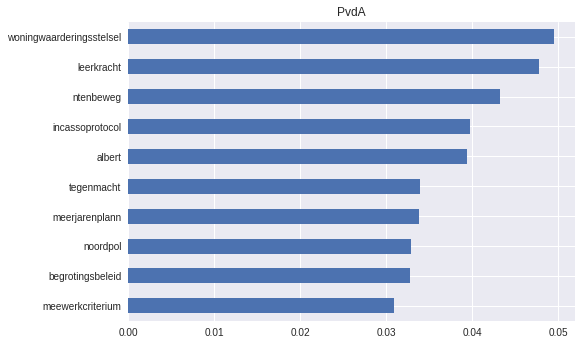

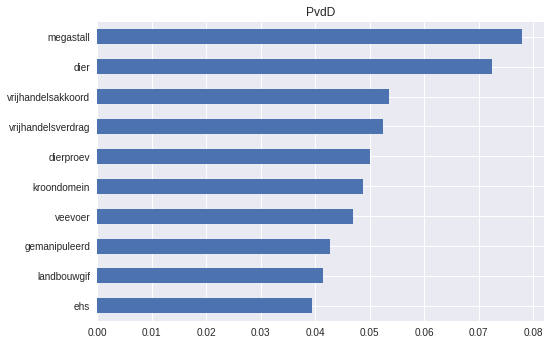

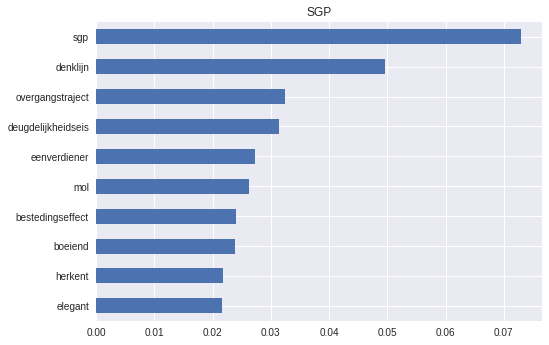

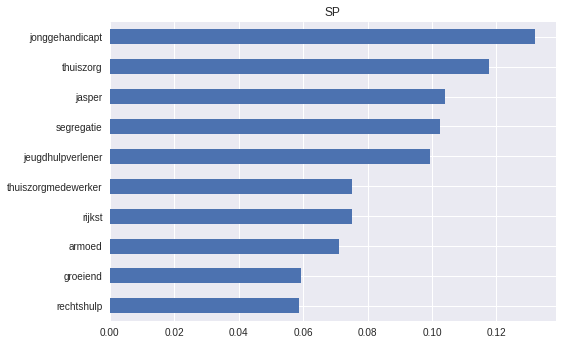

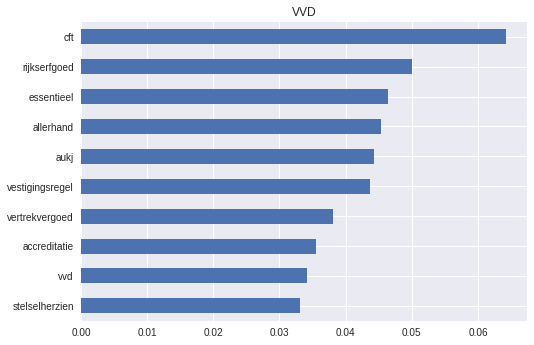

In [140]:
def print_top10(feature_names, clf):
    """Prints features with the highest coefficient values, per class"""
    class_labels = clf.classes_
    for i, class_label in enumerate(sorted(class_labels)):
        pd.Series(clf.coef_[i], index=feature_names).sort_values(ascending=False).head(10).plot.barh()
        plt.gca().invert_yaxis()
        plt.title(class_label)
        plt.show()
#         top10 = np.argsort(clf.coef_[i])[-10:]
#         print("%s: %s" % (class_label,
#               " ".join(feature_names[j] for j in top10)))
        
print_top10(terms, text_clf)

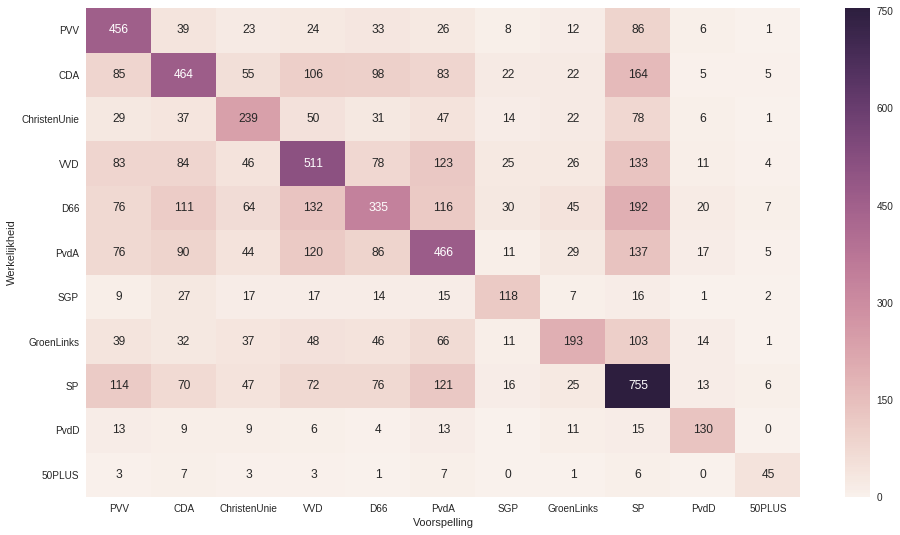

In [141]:
# from sklearn.preprocessing import normalize

partijen = data.dropna()['Partij'].unique()
cm = metrics.confusion_matrix(y_test, text_clf.predict(X_test), labels=partijen)

plt.figure(figsize=(16,9))
sns.heatmap(cm,
           yticklabels=partijen,
           xticklabels=partijen,
           annot=True,
           fmt='g')
plt.xlabel('Voorspelling')
plt.ylabel('Werkelijkheid')
plt.show()